<a href="https://colab.research.google.com/github/PedroDubas/Captcha_recognition/blob/master/Captcha_Recognizer_PLAY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#Download dos Captchas
import urllib.request

url = 'https://github.com/PedroDubas/Captcha_recognition/raw/master/samples.zip'
urllib.request.urlretrieve(url, '/content/samples.zip')

url = 'https://github.com/PedroDubas/Captcha_recognition/raw/master/melhor.hdf5'
urllib.request.urlretrieve(url, '/content/melhor.hdf5')

('/content/melhor.hdf5', <http.client.HTTPMessage at 0x7fd838d65630>)

In [0]:
!unzip -q samples.zip 

In [6]:
import cv2
from PIL import Image
import imutils
import zipfile
from google.colab.patches import cv2_imshow
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint

from __future__ import print_function
import sys


import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


##Re-cria a Rede Neural

In [7]:
modelin = Sequential()

modelin.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (28,28,1)))
modelin.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
modelin.add(MaxPool2D(pool_size=(2,2)))
modelin.add(Dropout(0.25))

modelin.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
modelin.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
modelin.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
modelin.add(Dropout(0.25))


modelin.add(Flatten())
modelin.add(Dense(256, activation = "relu"))
modelin.add(Dropout(0.25))
modelin.add(Dense(19, activation = "softmax"))

#Carrega os pesos
modelin.load_weights('melhor.hdf5')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
classes = ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']

In [0]:
lista_coluna =['label']
for numero in range(0,784):
    lista_coluna.append('pixel'+str(numero))

treino = pd.DataFrame(columns=lista_coluna)

In [0]:
def leCaptcha(caminho,debug=False,treino = treino):
    img = cv2.imread(caminho, 0)
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]


    kernel = np.ones((3,3), np.uint8)
    dilation3 = cv2.dilate(th3, kernel, iterations=1)
    erosion3 = cv2.erode(dilation3, kernel, iterations=1)
    
    kernel = np.ones((3,1), np.uint8)
    dilation3 = cv2.dilate(erosion3, kernel, iterations=1)


    #Posicionamento para pegar as letras individualmente da imagem
    x, y, w, h = 30, 12, 21, 36
    idx=0
    for  i in range(5):        
        crop_img = dilation3[y:y+h, x:x+w]
        
        #Altera o tamanho dos cortes para 28x28 um tamanho fixo, e mais facil para nossa rede trabalhar em cima mais tarde.
        image_resized = resize(crop_img, (28.0, 28.0),anti_aliasing=True).astype("int32") 
        rows,cols = image_resized.shape 
        img_size = rows*cols
        
        #Converte a imagem antes em uma Matrix, para um arrey de 784 posicoes
        img_1D_vector = image_resized.reshape(img_size)
        lista = img_1D_vector.tolist()
        lista.insert(0,str(caminho[-9:][i]))
        
        new_row = pd.DataFrame(columns=treino.columns,data=[lista]) 
        treino = treino.append(new_row,ignore_index=True)   
        x += w
        idx +=1
        if debug:
          plt.subplot(330 + (i+1))
          plt.imshow(image_resized, 'gray')
        
    if debug:    
      plt.show()

      plt.imshow(img, 'gray')
      plt.show()

      plt.imshow(dilation3, 'gray')
      plt.title('Contouring')
      plt.show()
    
    captcha = (treino.iloc[:,1:].values).astype('float32')
    captcha = captcha.reshape(-1,28,28,1)
    #Predict
    captcha_pred = modelin.predict(captcha)
    
    captcha_pred_classes = np.argmax(captcha_pred,axis = 1)
    
    resp =''
    for letra_pred in captcha_pred_classes:
        resp = resp+ str(classes[letra_pred])
    if debug: print('CAPTCHA ======> :' +resp)
    
    return resp



In [25]:
print(leCaptcha('samples/cgcgb.png',False))
print(leCaptcha('samples/23n88.png',False))
print(leCaptcha('samples/bd3b7.png',False))
print(leCaptcha('samples/ybfx6.png',False))
print(leCaptcha('samples/c8n8c.png',False))

cgcgb
23n88
bd3b7
ybfx6
c8n8c


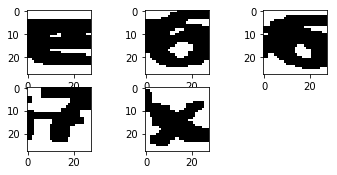

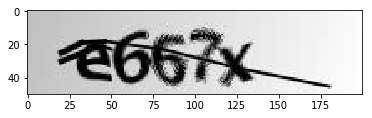

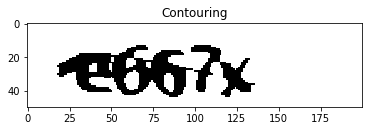

CAPTCHA ======> :e667x


'e667x'

In [26]:
leCaptcha('samples/e667x.png',True)